# pystrat-tutorial

This Jupyter notebook is intended to demonstrate core *pystrat* functionality.

The *pystrat* package is available here: https://github.com/yuempark/pystrat and can also be installed via `pip`: `pip install pystrat`

The data used for demonstration purposes in this notebook comes from a stratigraphic section measured in the Tonian-Cryogenian Tambien Group of northern Ethiopia. The significance of the Tambien Group for understanding Neoproterozoic Earth history is currently detailed in the following three studies:

* Swanson-Hysell, N.L., Maloof, A.C., Condon, D.J., Jenkin, G.R., Alene, M., Tremblay, M.M., Tesema, T., Rooney, A.D., and Haileab, B., 2015, Stratigraphy and geochronology of the Tambien Group, Ethiopia: Evidence for globally synchronous carbon isotope change in the Neoproterozoic: Geology, v. 43, p. 323-326, https://doi.org/10.1130/G36347.1.

* MacLennan, S.A., Park, Y., Swanson-Hysell, N.L., Maloof, A.C., Schoene, B., Gebreslassie, M., Antilla, E., Tesema, T., Alene, M., and Haileab, B., 2018, The arc of the Snowball: U-Pb dates constrain the Islay anomaly and the initiation of the Sturtian glaciation: Geology, v. 46, p. 539-542, https://doi.org/10.1130/G40171.1.

* Park, Y., Swanson-Hysell, N.L., MacLennan, S.A., Maloof, A.C., Gebreslassie, M., Tremblay, M.M., Schoene, B., Alene, M., Anttila, E.S.C., Tesema, T., Condon, D.J., Haileab, B., 2020, The lead-up to the Sturtian Snowball Earth: Neoproterozoic chemostratigraphy time-calibrated by the Tambien Group of Ethiopia: GSA Bulletin, vol. 132, pp. 1119–1149, https://doi.org/10.1130/B35178.1 

## Install pystrat

If you do not have pystrat installed, running the code cell below will install it:

In [1]:
!pip install pystrat

## Import `pystrat` and other scientific python packages

In [1]:
%load_ext autoreload
%autoreload 2

# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# pystrat
from pystrat import pystrat

(CVXPY) Sep 11 09:55:09 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


## Quick Start

If you'd just like get your stratigraphic section plotted up quickly, the code below will get you started (provided that your data is set up appropriately). For a more in-depth description of *pystrat* functionality and advanced features, refer to the [Advanced Tutorial](#Advanced-Tutorial) section.

In [2]:
%matplotlib inline

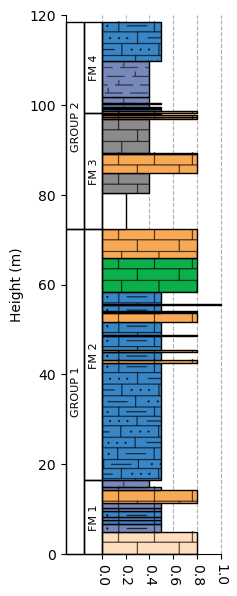

In [3]:
# read in your lithostratigraphy data
litho_df = pd.read_csv('example-data/lithostratigraphy.csv')

# read in your style file
style_df = pd.read_csv('example-data/style.csv')

# create a pystrat Section from the lithostratigraphy data
section_01 = pystrat.Section(litho_df['THICKNESS'],           # unit thicknesses
                             litho_df['FACIES'],              # unit facies
                             units=litho_df[['GROUP', 'FORMATION']].values) # group and formation names
# create a pystrat Style from the styling files
style_01 = pystrat.Style(style_df['facies'],                  # labels (must include all unique facies)
                         style_df[['R','G','B']]/255,         # colors 
                         style_df['width'],                   # widths 
                         swatch_values=style_df['swatch'])    # optional swatch codes

# plot the Section using the Style
fig = plt.figure(figsize=(2, 7))
# note that due to how swatches are plotted, it is preferrable to define an Axes object with a specified
# ylim to accommodate the section
ax = plt.axes(ylim=[0, 120])   
section_01.plot(style_01, ax=ax, label_units=True, unit_label_wid_tot=0.3)
plt.show()

**A note on figure workflows:**

You can save any figure by adding the following line before the `plt.show()` command:

```python
plt.savefig('<name_of_figure>.pdf', bbox_inches='tight')
```

The format of the saved figure is specified with the extension of the file name (example above uses pdf).

The `bbox_inches` keyword argument ensures that the figure will not be cropped upon saving.

By default, *matplotlib* exports figures with all labels and text annotations converted to vector paths. However, it is often preferable to preserve these as text objects so that font, font size, etc. can easily be manipulated when importing the figure into vector-editing software. To do this, add one of the following lines (depending on your preferred format) to a new cell and execute it.

```python
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
```

## Advanced Tutorial

*pystrat* strives to take advantage of object-oriented programming (OOP) by organizing stratigraphic data into [classes](https://docs.python.org/3/tutorial/classes.html).

The core class upon which this package is built is the `Section` class, which organizes the measured stratigraphic log (i.e. the thicknesses and facies of units).

Any additional data that is tied to the stratigraphic height, but not explicitly tied to the individually measured units, is organized in the `Data` subclass.

The plotting style for a stratigraphic section is organized in the `Style` class.

### Organizing your Data

---

**Read in the measured section.**

In this case, the data is stored in a .csv:

In [4]:
litho = pd.read_csv('example-data/lithostratigraphy.csv')
litho.head()

,THICKNESS,FACIES,LITHOLOGY,GROUP,FORMATION
0,4.9,recrystallized,dolomite,GROUP 1,FM 1
1,1.8,ribbonite-siltstone,dolomite,GROUP 1,FM 1
2,0.8,ribbonite,dolomite,GROUP 1,FM 1
3,0.7,ribbonite-siltstone,dolomite,GROUP 1,FM 1
4,1.4,ribbonite,dolomite,GROUP 1,FM 1


---
**Initialize a `Section` object.**

A measured stratigraphic section is fundamentally comprised of discrete units, each with a their own stratigraphic thickness and facies. *pystrat* and the `Section` object is built upon this fundamental framework.

Therefore, we initialize the `Section` object with the stratigraphic thicknesses and facies of these units, extracted from the pandas dataframe we read in above:

In [5]:
section_01 = pystrat.Section(litho['THICKNESS'], litho['FACIES'])

---
**Access `Section` attributes.**

*pystrat* takes advantage of object-oriented programming (OOP). After initialization, a `Section` object will automatically have a few basic attributes:

* `thicknesses`
    * stratigraphic thicknesses of each unit
* `facies`
    * facies of each unit
* `n_units`
    * number of units
* `total_thickness`
    * total stratigraphic thickness
* `base_height`
    * stratigraphic height at the base of each unit
* `top_height`
    * stratigraphic height at the top of each unit
* `unit_number`
    * a key for each unit
* `unique_facies`
    * unique facies
* `n_unique_facies`
    * number of unique facies
* `facies_attributes`
    * names of attributes associated with the stratigraphic units
* `data_attributes`
    * names of attributes associated with the stratigraphic height (see below)
* `generic_attributes`
    * names of generic attributes associated with neither the stratigraphic height nor the stratigraphic units (see below)
    
These attributes can be accessed in the following way:

In [6]:
section_01.total_thickness

118.4

---
**Add attributes associated with the stratigraphic units.**

Often, there will be additional data associated with the units in the stratigraphic section.

We can add an arbitrary number of such attributes using the `add_facies_attribute()` method:

In [7]:
section_01.add_facies_attribute('lithology', litho['LITHOLOGY'])

Again, these attributes can then be accessed in the following way (slicing out the first 5 values for illustrative purposes):

In [8]:
section_01.lithology[:5]

array(['dolomite', 'dolomite', 'dolomite', 'dolomite', 'dolomite'],
      dtype=object)

---
**Recover attributes associated with the stratigraphic units.**

The attributes associated with the stratigraphic units can be easily recovered using the `return_facies_dataframe()` method:

In [9]:
facies_dataframe = section_01.return_facies_dataframe()
facies_dataframe.head()

,unit_number,thicknesses,base_height,top_height,facies,lithology
0,0,4.9,0.0,4.9,recrystallized,dolomite
1,1,1.8,4.9,6.7,ribbonite-siltstone,dolomite
2,2,0.8,6.7,7.5,ribbonite,dolomite
3,3,0.7,7.5,8.2,ribbonite-siltstone,dolomite
4,4,1.4,8.2,9.6,ribbonite,dolomite


---
**Add attributes associated with the stratigraphic height.**

Often, there will also be data tied to the stratigraphic height rather than the stratigraphic units. *pystrat* organizes such data using the `Data` subclass.

A typical example of such an attribute would be chemostratigraphic data. Here, we read in some chemostratigraphic data:

In [10]:
chemo = pd.read_csv('example-data/chemostratigraphy.csv')
chemo.head()

,CARB_SAMPLE,CARB_HEIGHT,CARB_d13C,CARB_d18O,CARB_87Sr/86Sr,CARB_Al_ppm,CARB_Ca_ppm,CARB_Fe_ppm,CARB_Mg_ppm,CARB_Mn_ppm,CARB_Sr_ppm
0,T46-1.2,1.2,1.820429,0.130692,NaN,682.46931,313906.3927,293.408791,197499.6646,443.552746,539.226752
1,T46-2.1,2.1,1.597633,0.134841,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T46-3.8,3.8,0.102096,-0.195867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T46-5.9,5.9,1.090520,-1.066232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T46-7.1,7.1,2.194324,-0.630248,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add the $\delta^{13}$C data using the `add_data_attribute()` method:

In [11]:
section_01.add_data_attribute('d13C', chemo['CARB_HEIGHT'], chemo['CARB_d13C'])

This will create a `Data` subclass with the following attributes:

* `height`
    * stratigraphic height of the data
* `values`
    * values of the data
* `n_values`
    * number of values
* `height_attributes`
    * names of attributes associated with this array of stratigraphic heights
* `generic_attributes`
    * names of generic attributes associated with this `Data` object
    
These attributes can be accessed in the following way:

In [12]:
section_01.d13C.n_values

82

We can also add further attributes to this particular `Data` subclass using the `add_height_attribute()` method (for example, the sample names associated with the $\delta^{13}$C data):

In [13]:
section_01.d13C.add_height_attribute('sample', chemo['CARB_SAMPLE'])

Again, we can access these new attributes in the following way (slicing out the first 5 values for illustrative purposes):

In [14]:
section_01.d13C.sample[:5]

array(['T46-1.2', 'T46-2.1', 'T46-3.8', 'T46-5.9', 'T46-7.1'],
      dtype=object)

And we can recover them using the `return_data_dataframe()` method:

In [15]:
d13C_dataframe = section_01.d13C.return_data_dataframe()
d13C_dataframe.head()

,height,values,sample
0,1.2,1.820429,T46-1.2
1,2.1,1.597633,T46-2.1
2,3.8,0.102096,T46-3.8
3,5.9,1.090520,T46-5.9
4,7.1,2.194324,T46-7.1


We can follow the same workflow to add the rest of the chemostratigraphic data:

In [16]:
# d18O
section_01.add_data_attribute('d18O', chemo['CARB_HEIGHT'], chemo['CARB_d18O'])
section_01.d18O.add_height_attribute('sample', chemo['CARB_SAMPLE'])

# 87Sr/86Sr
section_01.add_data_attribute('Sr87Sr86', chemo['CARB_HEIGHT'], chemo['CARB_87Sr/86Sr'])
section_01.Sr87Sr86.add_height_attribute('sample', chemo['CARB_SAMPLE'])

# Al
section_01.add_data_attribute('Al', chemo['CARB_HEIGHT'], chemo['CARB_Al_ppm'])
section_01.Al.add_height_attribute('sample', chemo['CARB_SAMPLE'])

# Ca
section_01.add_data_attribute('Ca', chemo['CARB_HEIGHT'], chemo['CARB_Ca_ppm'])
section_01.Ca.add_height_attribute('sample', chemo['CARB_SAMPLE'])

# Fe
section_01.add_data_attribute('Fe', chemo['CARB_HEIGHT'], chemo['CARB_Fe_ppm'])
section_01.Fe.add_height_attribute('sample', chemo['CARB_SAMPLE'])

# Mg
section_01.add_data_attribute('Mg', chemo['CARB_HEIGHT'], chemo['CARB_Mg_ppm'])
section_01.Mg.add_height_attribute('sample', chemo['CARB_SAMPLE'])

# Mn
section_01.add_data_attribute('Mn', chemo['CARB_HEIGHT'], chemo['CARB_Mn_ppm'])
section_01.Mn.add_height_attribute('sample', chemo['CARB_SAMPLE'])

# Sr
section_01.add_data_attribute('Sr', chemo['CARB_HEIGHT'], chemo['CARB_Sr_ppm'])
section_01.Sr.add_height_attribute('sample', chemo['CARB_SAMPLE'])

We can also follow the same workflow to add a non-chemostratigraphic dataset tied to the stratigraphic height - in this case geochronology samples:

In [17]:
geochron = pd.read_csv('example-data/geochronology.csv')
geochron.head()

,ASH_SAMPLE,ASH_HEIGHT,ASH_AGE,ASH_AGE_2SIGMA
0,T46-102.2z,102.2,735.25,0.25


In [18]:
section_01.add_data_attribute('ages', geochron['ASH_HEIGHT'], geochron['ASH_AGE'])
section_01.ages.add_height_attribute('sample', geochron['ASH_SAMPLE'])

Remember that the names of all added attributes tied to the stratigraphic height can be accessed in the following way:

In [19]:
section_01.data_attributes

['d13C', 'd18O', 'Sr87Sr86', 'Al', 'Ca', 'Fe', 'Mg', 'Mn', 'Sr', 'ages']

---
**Add generic attributes.**

We can also add generic attributes to the `Section` that are neither tied to the stratigraphic height nor the stratigraphic units using the `add_generic_attribute()` method.

For example, here we add an attribute that contains the stratigraphic formations that were measured in this section:

In [20]:
section_01.add_generic_attribute('formations', ['Didikama','Matheos'])
section_01.formations

['Didikama', 'Matheos']

### Setting the Styling

To plot a stratigraphic section, the `Section` must be accompanied by a compatible `Style`. This `Style` class organizes the plotting style specified by the user.

**Read in the styling.**

The plotting style is specified in [`style.csv`](example-data/style.csv), where widths, colors, and (optionally) swatches are specified for each facies.

In [21]:
style_df = pd.read_csv('example-data/style.csv')
style_df.head()

,facies,R,G,B,width,swatch
0,cover,255,255,255,0.2,0
1,grainstone,248,169,85,0.8,627
2,intraclast breccia,200,100,255,1.0,605
3,marl,119,136,187,0.4,623
4,marl-ribbonite,119,136,187,0.4,623


---
**Initialize a `Style` object.**

Values need to be assigned to seven core attributes during initialization:

* `labels`
    * facies against which to match in the section for styling.
* `color_values`
    * the colors that will be assigned to the associated labels
* `width_values`
    * the widths (between 0 and 1) that will be assigned to the associated labels
* `swatch_values`
    * optional USGS swatch codes to plot on units
* `annotations`
    * dictionary that specifies paths to graphics for annotation tags that might occur in sections
* `swatch_wid`
    * width of the swatch pattern in inches; can be changed to scale the pattern for various figure sizes.

In [22]:
style_01 = pystrat.Style(style_df['facies'],                  # labels (must include all unique facies)
                         style_df[['R','G','B']]/255,         # colors 
                         style_df['width'],                   # widths 
                         swatch_values=style_df['swatch']) 

---
**Visualize the `Style`.**

We can create a legend for any `Style` using the `plot_legend()` method:

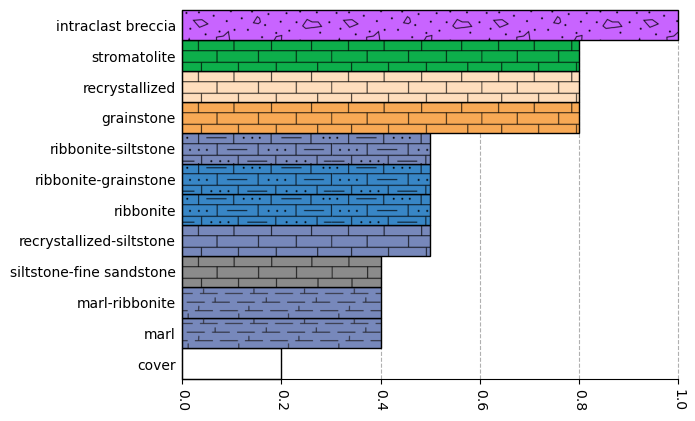

In [23]:
style_01.plot_legend()

### Plotting a Section

**Check that the `Section` is compatible with the `Style`.**

As described above, the `Style` must specify attributes and labels that are compatible with any given `Section`. The `section_style_compatibility()` function tests this compatibility:

In [24]:
section_01.style_compatibility(style_01)

True

---
**Plot the `Section`**.

Plotting a stratigraphic section on its own is straight-forward - we simply use the `Section.plot()` function.

If a user does not specify an `Axes` object to plot into, the `plot()` function will create one automatically. It can be convenient to manually create an `Axes` object and specify the vertical axis limits ahead of time, but it is not necessary to do so. 

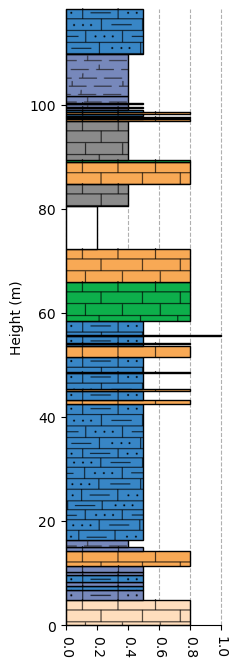

In [25]:
fig = plt.figure(figsize=(2, 8))

section_01.plot(style_01)

---
**Plotting additional data.**

Additional data can be plotted alongside the stratigraphic section by changing `ncols` in the `plot_stratigraphy()` function, in a manner similar to that when using `plt.subplots()`. Additional data can then easily be plotted on top of these pre-generated axes:

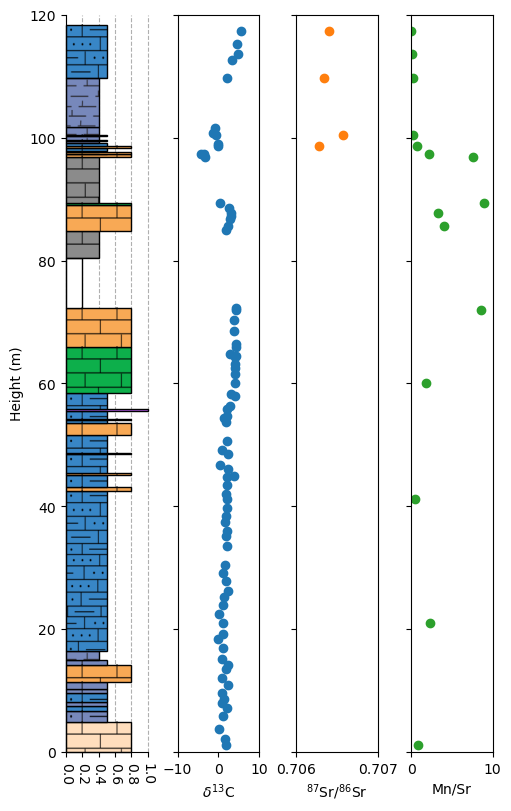

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(5, 8), sharey=True, constrained_layout=True)
ax[0].set_ylim([0, 120])

section_01.plot(style_01, ax=ax[0])

ax[1].scatter(section_01.d13C.values, section_01.d13C.height, c='C0')
ax[1].set_xlim(-10,10)
ax[1].set_xlabel('$\delta^{13}$C')

ax[2].scatter(section_01.Sr87Sr86.values, section_01.Sr87Sr86.height, c='C1')
ax[2].set_xlim(0.7060,0.7070)
ax[2].set_xlabel('$^{87}$Sr/$^{86}$Sr')

ax[3].scatter(section_01.Mn.values/section_01.Sr.values, section_01.Sr.height, c='C2')
ax[3].set_xlim(0,10)
ax[3].set_xlabel('Mn/Sr')

plt.show(fig)

### Fence Diagrams

This portion of the tutorial illustrates the use of the `Fence` class to plot stratigraphic columns alongside each other, using data from:
Park, Y., Swanson-Hysell, N.L., MacLennan, S.A., Maloof, A.C., Gebreslassie, M., Tremblay, M.M., Schoene, B., Alene, M., Anttila, E.S.C., Tesema, T., Condon, D.J., Haileab, B., 2019, The lead-up to the Sturtian Snowball Earth: Neoproterozoic chemostratigraphy time-calibrated by the Tambien Group of Ethiopia: GSA Bulletin, vol. TBD, pp. TBD, https://doi.org/10.1130/B35178.1

Specifically, we will recreate part of Figure 13 showing 4 sections from the Samre fold-thrust belt.

The requisite sections and styling are in the [repository](https://github.com/Swanson-Hysell-Group/2019_Tambien_Group/tree/5df831c3c72207c6ef66cb7119851c4e43cb5e95/Code/Tambien_Stratigraphy) for that manuscript, and they have been downloaded to the `example-data/Tambien_fence` folder of this repository.

First, we load the section spreadsheets and create the `Section` objects like usual.

In [27]:
section_files = {'T49': 'example-data/Tambien_fence/T49.csv',
                 'T50': 'example-data/Tambien_fence/T50.csv',
                 'T61': 'example-data/Tambien_fence/T61.csv',
                 'T64': 'example-data/Tambien_fence/T64.csv'}

sections = []
for section_name, section_file in section_files.items():
    cur_df = pd.read_csv(section_file)
    cur_section = pystrat.Section(cur_df['THICKNESS'],
                                  cur_df['GRAIN_SIZE'],
                                  name=section_name)  # take section name from file name
    sections.append(cur_section)

We also need the `Style` object, which we create as before.

In [28]:
style_df = pd.read_csv('example-data/Tambien_fence/style.csv')

# create a pystrat Style from the styling files
style_02 = pystrat.Style(style_df['GRAIN_SIZE'],                 
                         style_df[['r','g','b']]/255,        
                         style_df['width'])   

Having created the sections, we can create the `Fence` object. `Fence`s can have datums that define the origin in height, as well as correlations, which define tie points between columns. Both are defined similarly:
- the datum is specified as an array with an entry for each `Section` in the `Fence`, where the value of the entry is the height of the datum horizon in that section
- correlations are defined in the same way, except that because there can be multiple correlated horizons, the correlations parameter expects a 2D array. The columns in this array correpond to each correlated horizon, and the rows correspond to each section.

In the example below, we also specify a coordinates parameter, which locates the sections with respect to each other. The spacing of sections in the fence diagram can be scaled to their physical separations by setting `distance_spacing=True` in the `Fence.plot()` call. Note that the coordinates array is not the _distances_ between sections, but rather their locations along a line or transect that all the sections are projected onto. 

In the case below, we've just given the sections coordinates that correspond to their ordering in the manuscript's figure. Specifically, the first section (`sections[0]`) is T49, but this section is actually second in the fence diagram, so we give it a coordinate of 2. If coordinates are not specified, then sections are evenly spaced and plotted according to the order in which they occur in the list provided to the `Fence` object.

In [29]:
datum = np.array([22.9, 99, 338.9, 79.5]).reshape(-1, 1) # datum is a 1D array

In [30]:
fence = pystrat.Fence(sections, 
                      coordinates=np.array([2, 3, 1, 4]),
                      datums=datum)

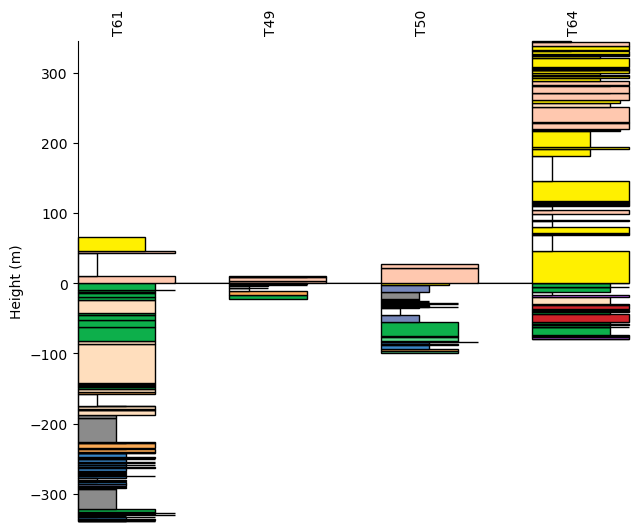

In [31]:
fig, ax = fence.plot(style_02)

This is a barebones `Fence` diagram, but the plotting function permits complex behaviors, such as the plotting and styling of data attributes (even if not all sections in the fence have the same data attributes). You can additionally include a legend in a fence plot, as well as label distances between sections.

### Additional Functionality

**Extract the facies associated with a given sample.**

We can automatically extract the facies associated with each sample in a `Data` object using `add_data_facies()`:

In [32]:
# get the facies for each sample
section_01.d13C.add_data_facies(section_01)

# pull out the dataframe
d13C_dataframe = section_01.d13C.return_data_dataframe()
d13C_dataframe

,height,values,sample,facies,unit_number
0,1.2,1.820429,T46-1.2,recrystallized,0.0
1,2.1,1.597633,T46-2.1,recrystallized,0.0
2,3.8,0.102096,T46-3.8,recrystallized,0.0
3,5.9,1.090520,T46-5.9,ribbonite-siltstone,1.0
4,7.1,2.194324,T46-7.1,ribbonite,2.0
...,...,...,...,...,...
77,109.7,2.092839,T46-109.7,!!!ON BOUNDARY!!!,42.5
78,112.6,3.220129,T46-112.6,ribbonite-grainstone,43.0
79,113.7,4.774569,T46-113.7,ribbonite-grainstone,43.0
80,115.3,4.524742,T46-115.3,ribbonite-grainstone,43.0


However, some samples may fall on unit boundaries, in which case the facies of the sample is ambiguous. The facies of such samples will have to be manually verified. We can use `clean_data_facies_helper()` and `clean_data_facies()` to assist us with this process:

In [33]:
section_01.d13C.clean_data_facies_helper('section_01.d13C')

1) Copy and paste the code below into a cell and edit as follows:
- If the sample comes from the lower unit, subtract 0.5.
- If the sample comes from the upper unit, add 0.5.

2) Run Data.clean_data_facies().
===
section_01.d13C.unit_number[7] = 4.5 #height = 9.6, sample = T46-9.6
section_01.d13C.unit_number[11] = 7.5 #height = 14.2, sample = T46-14.2
section_01.d13C.unit_number[37] = 14.5 #height = 48.5, sample = T46-48.5
section_01.d13C.unit_number[43] = 21.5 #height = 55.8, sample = T46-55.8
section_01.d13C.unit_number[54] = 23.5 #height = 65.9, sample = T46-65.9
section_01.d13C.unit_number[59] = 24.5 #height = 72.3, sample = T46-72.3
section_01.d13C.unit_number[66] = 28.5 #height = 89.4, sample = T46-89.4
section_01.d13C.unit_number[67] = 29.5 #height = 96.9, sample = T46-96.9
section_01.d13C.unit_number[68] = 30.5 #height = 97.3, sample = T46-97.3
section_01.d13C.unit_number[69] = 30.5 #height = 97.3, sample = T46-97.3
section_01.d13C.unit_number[70] = 32.5 #height = 97.7, sample 

In [34]:
# manually assign the unit_number here
section_01.d13C.unit_number[7] = 4 #height = 9.6, sample = T46-9.6
section_01.d13C.unit_number[11] = 7 #height = 14.2, sample = T46-14.2
section_01.d13C.unit_number[37] = 15 #height = 48.5, sample = T46-48.5
section_01.d13C.unit_number[43] = 21 #height = 55.8, sample = T46-55.8
section_01.d13C.unit_number[54] = 24 #height = 65.9, sample = T46-65.9
section_01.d13C.unit_number[59] = 24 #height = 72.3, sample = T46-72.3
section_01.d13C.unit_number[66] = 28 #height = 89.4, sample = T46-89.4
section_01.d13C.unit_number[67] = 30 #height = 96.9, sample = T46-96.9
section_01.d13C.unit_number[68] = 30 #height = 97.3, sample = T46-97.3
section_01.d13C.unit_number[69] = 31 #height = 97.3, sample = T46-97.3
section_01.d13C.unit_number[70] = 32 #height = 97.7, sample = T46-97.7
section_01.d13C.unit_number[73] = 39 #height = 99.6, sample = T46-99.6
section_01.d13C.unit_number[74] = 40 #height = 100.4, sample = T46-100.4
section_01.d13C.unit_number[77] = 42 #height = 109.7, sample = T46-109.7

In [35]:
# reassign the facies for each sample
section_01.d13C.clean_data_facies(section_01)

# pull out the dataframe
d13C_dataframe = section_01.d13C.return_data_dataframe()
d13C_dataframe

,height,values,sample,facies,unit_number
0,1.2,1.820429,T46-1.2,recrystallized,0
1,2.1,1.597633,T46-2.1,recrystallized,0
2,3.8,0.102096,T46-3.8,recrystallized,0
3,5.9,1.090520,T46-5.9,ribbonite-siltstone,1
4,7.1,2.194324,T46-7.1,ribbonite,2
...,...,...,...,...,...
77,109.7,2.092839,T46-109.7,marl-ribbonite,42
78,112.6,3.220129,T46-112.6,ribbonite-grainstone,43
79,113.7,4.774569,T46-113.7,ribbonite-grainstone,43
80,115.3,4.524742,T46-115.3,ribbonite-grainstone,43
